In [1]:
train_data = './data/train'
train_labels = './data/train.csv'
val_data = './data/val'
val_labels = './data/val.csv'

In [2]:
from utilities import GestureDataGenerator, plot_training_history, set_seed, get_callbacks, set_memorry_limit_for_tf
set_seed(seed=42)
# set_memorry_limit_for_tf()

mediapipe module not found. Skipping...


2024-12-02 16:12:45.545376: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 16:12:45.645738: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Random seed set to 42


In [3]:
load_fraction = 1.0             # Full data load
batch_size = 16                 # We are low on resources. We will go slow and steady.
image_size = (224, 224)

# Initialize the generator
train_generator = GestureDataGenerator(
    data_path=train_data,
    labels_csv=train_labels,
    batch_size=batch_size,
    image_size=image_size,
    augmentations={
        'rotation': 5,       # Rotate up to ±5 degrees
        'brightness': True,  # Random brightness adjustment
        'contrast': True,    # Random contrast adjustment
        'blur': True         # Apply Gaussian blur
    },    
    shuffle=True,
    load_fraction=load_fraction,
    debug=False,
    use_mediapipe=False,
)

val_generator = GestureDataGenerator(
    data_path=val_data,
    labels_csv=val_labels,
    batch_size=batch_size,
    image_size=image_size,
    augmentations=None,
    shuffle=False,
    load_fraction=1.0,
    debug=False,
    use_mediapipe=False,
)

# Get the first batch
X, y = train_generator[0]

# Print outputs
print("Input batch shape (X):", X.shape)  # Expected shape: (batch_size, sequence_length, 224, 224, 3)
print("Labels batch shape (y):", y.shape)  # Expected shape: (batch_size, num_classes)
print("First label in batch (one-hot):", y[0])

42 batches created, each of size 16, with 663 sequences of 30 images each. Use MediaPipe: False
7 batches created, each of size 16, with 100 sequences of 30 images each. Use MediaPipe: False
Input batch shape (X): (16, 30, 224, 224, 3)
Labels batch shape (y): (16, 5)
First label in batch (one-hot): [0. 0. 0. 1. 0.]


In [4]:
# Define parameters
sequence_length = train_generator.sequence_length  # Frames per video (from generator)
image_size = train_generator.image_size            # Image size (height, width)
num_classes = train_generator.num_classes          # Number of gesture classes
input_shape = (sequence_length, image_size[0], image_size[1], 3)  # Conv3D input shape

In [5]:
from tensorflow.keras import layers, models

# Define the CNN+LSTM model
model = models.Sequential([
    layers.Input(shape=input_shape),                        # Input layer (sequence of frames)
    
    # CNN layers to extract features from each frame
    layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu', padding='same')),
    layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2), padding='same')),
    
    layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same')),
    layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2), padding='same')),
    
    layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='relu', padding='same')),
    layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2), padding='same')),
    
    # Flatten the output to feed into LSTM
    layers.TimeDistributed(layers.Flatten()),
    
    # LSTM layer for sequence learning
    layers.GRU(32, return_sequences=False),
    
    # Output layer for classification
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Assuming 5 classes based on labels
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 224, 224, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 112, 112, 32)  0        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 112, 112, 64)  18496    
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 56, 56, 64)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 56, 56, 128)  7

2024-12-02 16:12:50.068025: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 16:12:50.155755: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46402 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:e1:00.0, compute capability: 8.9


In [6]:
model_save_location = 'best-models/Conv2D-32x64x128+GRU.keras'

In [7]:
checkpoint_callback, reduce_lr_callback, early_stopping_callback = get_callbacks(filepath = model_save_location, save_best_only=True)

Epoch 1/5


2024-12-02 16:12:55.233100: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700
2024-12-02 16:12:55.662656: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


42/42 [==============================] - 256s 6s/step - loss: 1.7598 - accuracy: 0.1885 - val_loss: 1.6072 - val_accuracy: 0.1800 - lr: 0.0010
Epoch 2/5
42/42 [==============================] - 44s 1s/step - loss: 1.6118 - accuracy: 0.2308 - val_loss: 1.5862 - val_accuracy: 0.3700 - lr: 0.0010
Epoch 3/5
42/42 [==============================] - 43s 1s/step - loss: 1.5940 - accuracy: 0.2670 - val_loss: 1.4900 - val_accuracy: 0.3600 - lr: 0.0010
Epoch 4/5
42/42 [==============================] - 43s 1s/step - loss: 1.5389 - accuracy: 0.3107 - val_loss: 1.4913 - val_accuracy: 0.3800 - lr: 0.0010
Epoch 5/5
42/42 [==============================] - 43s 1s/step - loss: 1.3417 - accuracy: 0.4495 - val_loss: 1.6011 - val_accuracy: 0.3100 - lr: 0.0010


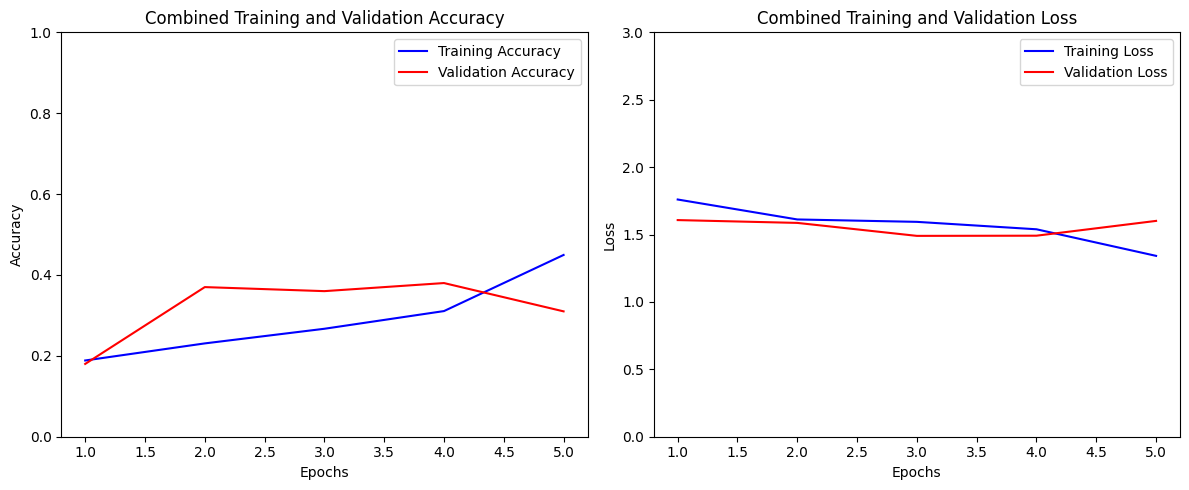

In [8]:
# Train the model
history_1 = model.fit(
    x=train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[checkpoint_callback, reduce_lr_callback, early_stopping_callback],
    verbose=1
)

plot_training_history(histories=[history_1])

Epoch 6/30
42/42 [==============================] - 44s 1s/step - loss: 1.3461 - accuracy: 0.4329 - val_loss: 1.4082 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 7/30
42/42 [==============================] - 44s 1s/step - loss: 1.2391 - accuracy: 0.5143 - val_loss: 1.2740 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 8/30
42/42 [==============================] - 43s 1s/step - loss: 1.1412 - accuracy: 0.5641 - val_loss: 1.3329 - val_accuracy: 0.4600 - lr: 0.0010
Epoch 9/30
42/42 [==============================] - 43s 1s/step - loss: 0.9427 - accuracy: 0.6637 - val_loss: 1.2514 - val_accuracy: 0.4900 - lr: 0.0010
Epoch 10/30
42/42 [==============================] - 43s 1s/step - loss: 0.8410 - accuracy: 0.6893 - val_loss: 1.0572 - val_accuracy: 0.5900 - lr: 0.0010
Epoch 11/30
42/42 [==============================] - 43s 1s/step - loss: 0.7117 - accuracy: 0.7421 - val_loss: 1.0518 - val_accuracy: 0.5900 - lr: 0.0010
Epoch 12/30
42/42 [==============================] - 43s 1s/step - loss: 0.7110 

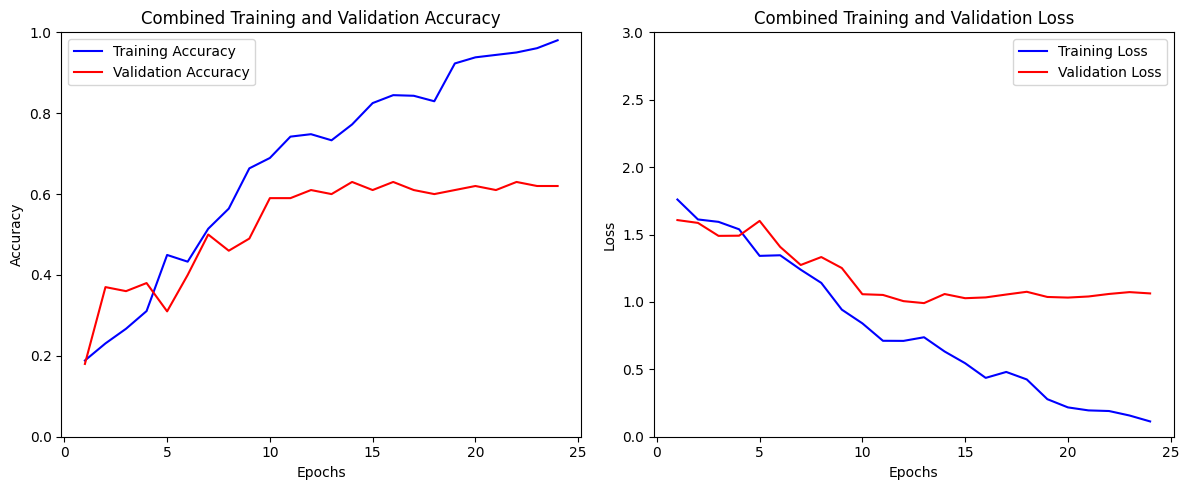

In [9]:
model.load_weights(model_save_location)

# Train the model for more epochs
history_2 = model.fit(
    x=train_generator,
    validation_data=val_generator,
    epochs=30,                  # Train for more epochs
    initial_epoch=5,            # Start counting previous epochs
    callbacks=[checkpoint_callback, reduce_lr_callback, early_stopping_callback],
    verbose=1
)

plot_training_history(histories=[history_1, history_2])

Epoch 31/50
42/42 [==============================] - 43s 1s/step - loss: 0.4614 - accuracy: 0.8612 - val_loss: 1.0495 - val_accuracy: 0.6000 - lr: 2.5000e-04
Epoch 32/50
42/42 [==============================] - 43s 1s/step - loss: 0.4020 - accuracy: 0.8627 - val_loss: 1.0303 - val_accuracy: 0.6100 - lr: 2.5000e-04
Epoch 33/50
42/42 [==============================] - 44s 1s/step - loss: 0.3579 - accuracy: 0.8929 - val_loss: 0.9818 - val_accuracy: 0.6500 - lr: 2.5000e-04
Epoch 34/50
42/42 [==============================] - 43s 1s/step - loss: 0.3195 - accuracy: 0.9065 - val_loss: 0.9819 - val_accuracy: 0.6400 - lr: 2.5000e-04
Epoch 35/50
42/42 [==============================] - 43s 1s/step - loss: 0.3304 - accuracy: 0.9080 - val_loss: 1.0003 - val_accuracy: 0.6200 - lr: 2.5000e-04
Epoch 36/50
42/42 [==============================] - 43s 1s/step - loss: 0.2905 - accuracy: 0.9035 - val_loss: 1.0030 - val_accuracy: 0.6100 - lr: 2.5000e-04
Epoch 37/50
42/42 [==============================] -

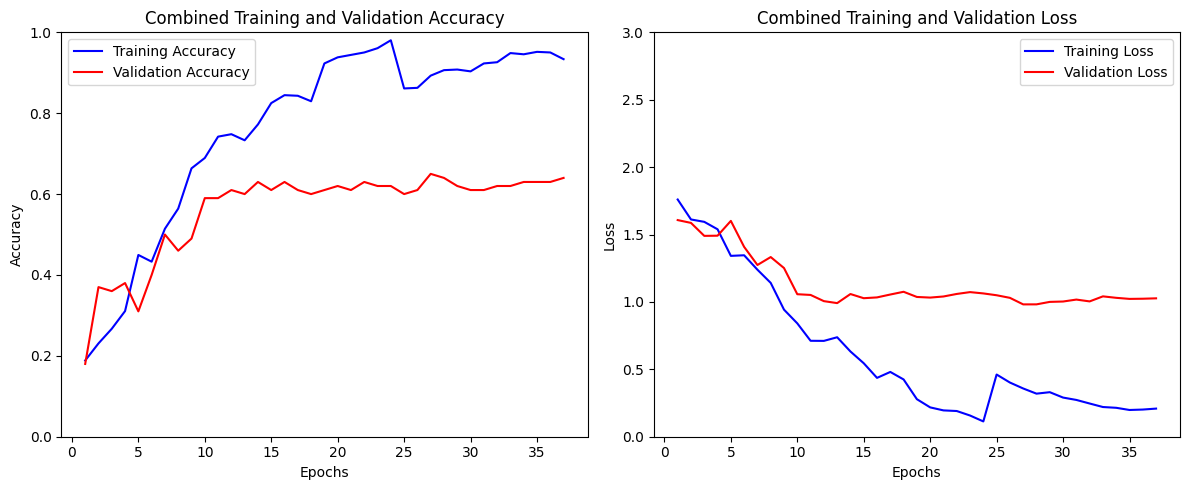

In [10]:
model.load_weights(model_save_location)

# Train the model for more epochs
history_3 = model.fit(
    x=train_generator,
    validation_data=val_generator,
    epochs=50,                   # Train for more epochs
    initial_epoch=30,            # Start counting previous epochs
    callbacks=[checkpoint_callback, reduce_lr_callback, early_stopping_callback],
    verbose=1
)

plot_training_history(histories=[history_1, history_2, history_3])

In [11]:
model.load_weights(model_save_location)

evaluation_results = model.evaluate(val_generator, verbose=1)

for metric, value in zip(model.metrics_names, evaluation_results):
    print(f"{metric}: {value:.4f}")

7/7 [==============================] - 5s 693ms/step - loss: 0.9818 - accuracy: 0.6500
loss: 0.9818
accuracy: 0.6500
